# An introduction to Gaussian Processes

## A work in progress!

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import cho_factor, cho_solve
from corner import corner

In [69]:
def draw_from_gaussian(mu, K, ndraws=1, eps=1e-12):
    """
    Generate samples from a multivariate gaussian
    specified by covariance ``K`` and mean ``mu``.
    
    """
    npts = K.shape[0]
    L, _ = cho_factor(K + eps * np.eye(npts), lower=True)
    L = np.tril(L)
    u = np.random.randn(npts, ndraws)
    x = np.dot(L, u) + mu[:, None]
    return x

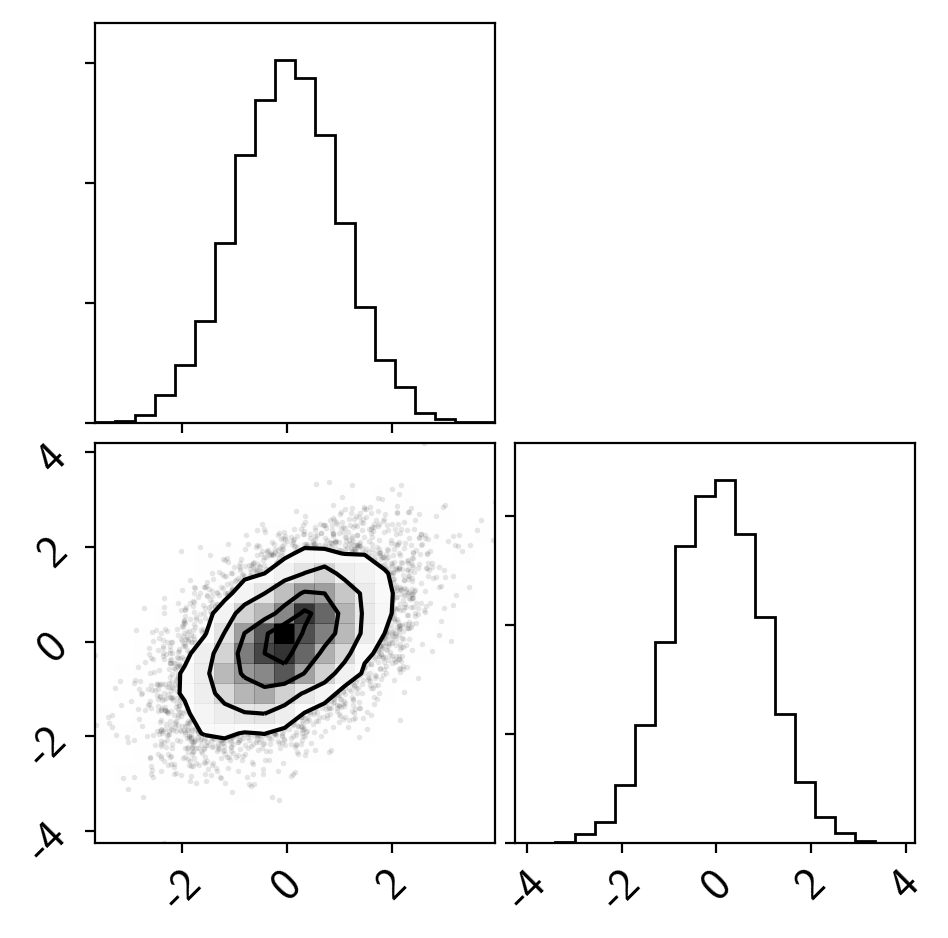

In [71]:
mu = np.zeros(2)
K = np.array([[1.0, 0.5], [0.5, 1.0]])
samples = draw_from_gaussian(mu, K, ndraws=10000).T
fig = corner(samples);

In [92]:
def ExpSinSquaredKernel(x1, x2=None, a=1.0, l=1.0):
    """
    Return the ``N x M`` exponential sine squared
    covariance matrix.
    
    """
    if x2 is None:
        x2 = x1
    X2, X1 = np.meshgrid(x2, x1)
    return a ** 2 * np.exp(-0.5 * (X1 - X2) ** 2 / l ** 2)

In [73]:
t = np.linspace(0, 10, 1001)

In [76]:
mu = np.zeros_like(t)
K = ExpSinSquaredKernel(t)

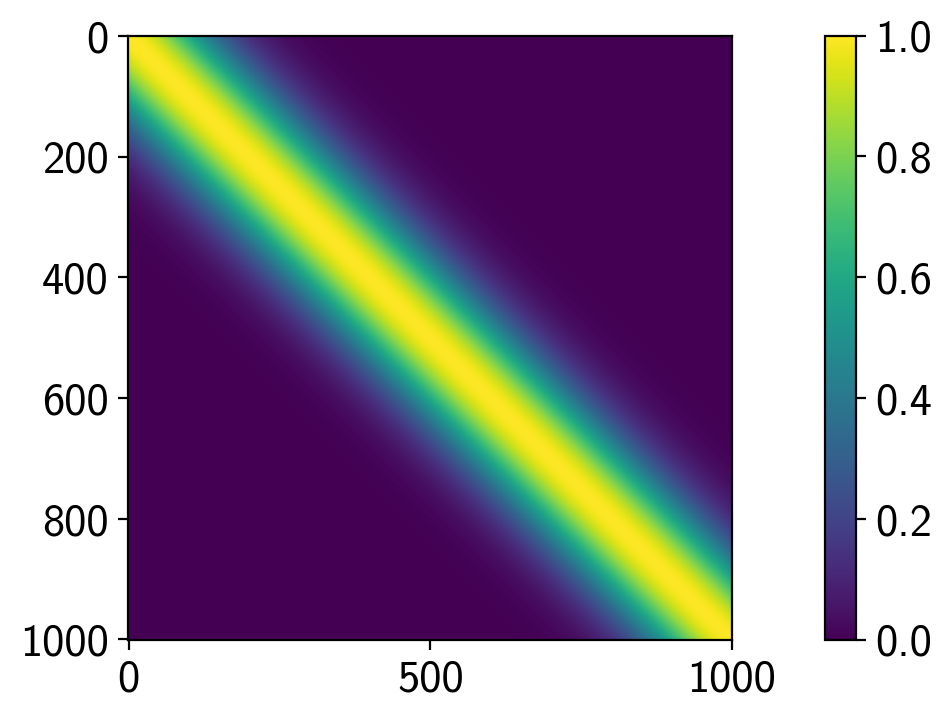

In [75]:
plt.imshow(K)
plt.colorbar();

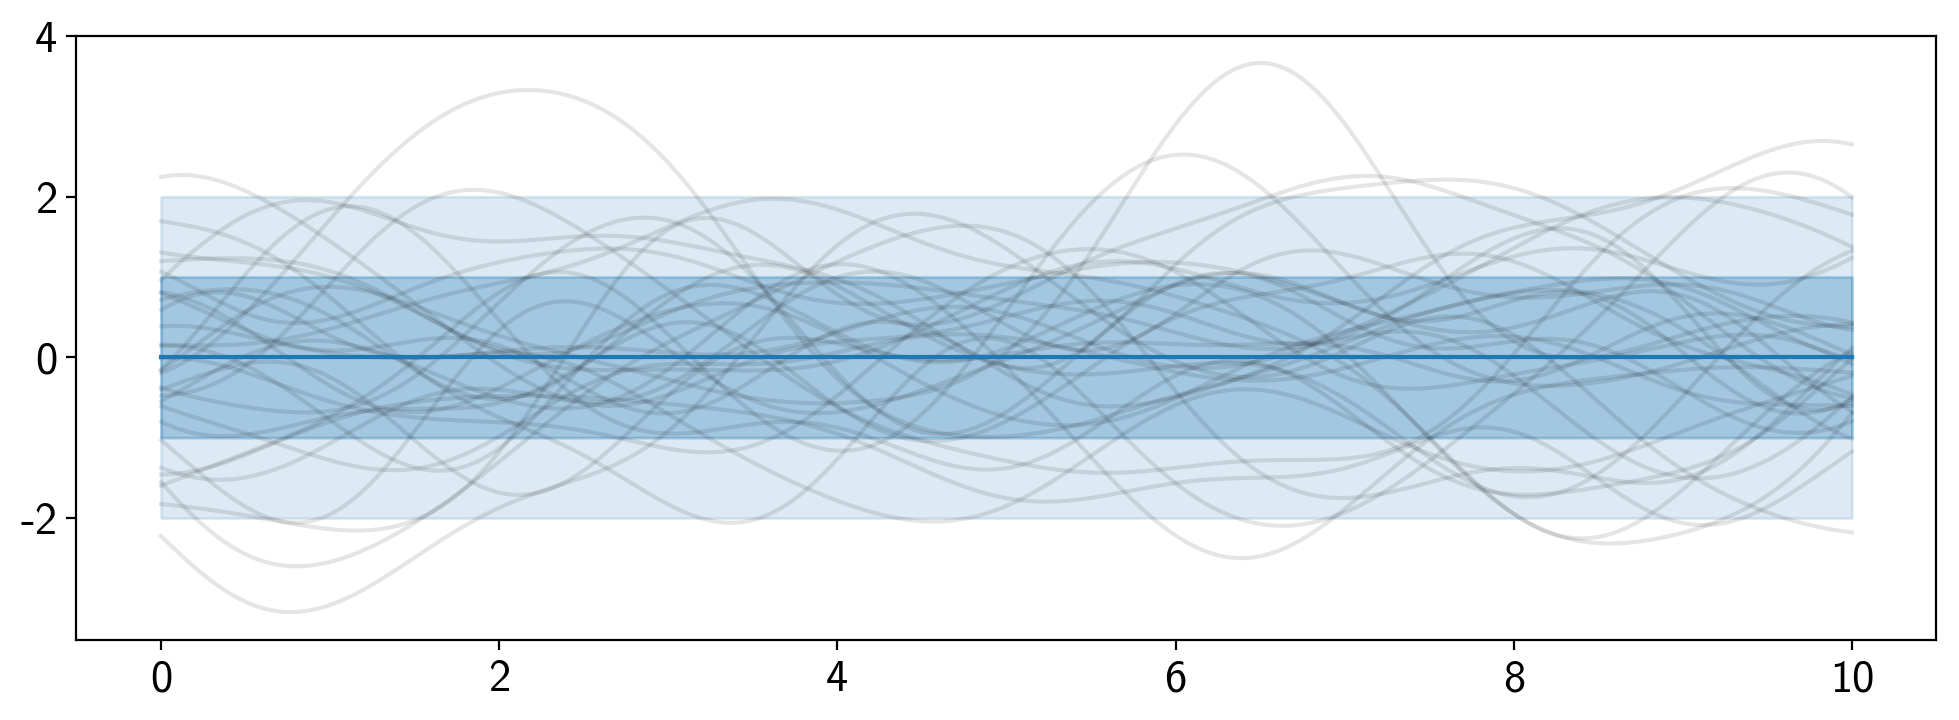

In [77]:
for i in range(30):
    samples = draw_from_gaussian(mu, K)
    plt.plot(t, samples, color="k", alpha=0.1)

mu_ = np.zeros_like(t)
plt.plot(t, mu_, color="C0")
std_ = np.sqrt(K.diagonal())
plt.fill_between(t, mu_ - std_, mu_ + std_, color="C0", alpha=0.3);
plt.fill_between(t, mu_ - 2 * std_, mu_ + 2 * std_, color="C0", alpha=0.15);

In [82]:
def compute_gp(ttest, ftest, tpred, sigma=0, kernel=ExpSinSquaredKernel, **kwargs):
    """
    
    """
    # Compute the required matrices
    Ktt = kernel(ttest, **kwargs)
    Ktt += sigma ** 2 * np.eye(Ktt.shape[0])
    Kpp = kernel(tpred, **kwargs)
    Kpt = kernel(tpred, ttest, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Kpt, np.linalg.solve(Ktt, ftest))
    K = Kpp - np.dot(Kpt, np.linalg.solve(Ktt, Kpt.T))
    
    return mu, K    

In [90]:
ttest = np.array([2.5, 7.5])
ftest = np.array([1.0, -1.0])
tpred = np.linspace(0, 10, 1001)

gp_mu, gp_K = compute_gp(ttest, ftest, tpred)

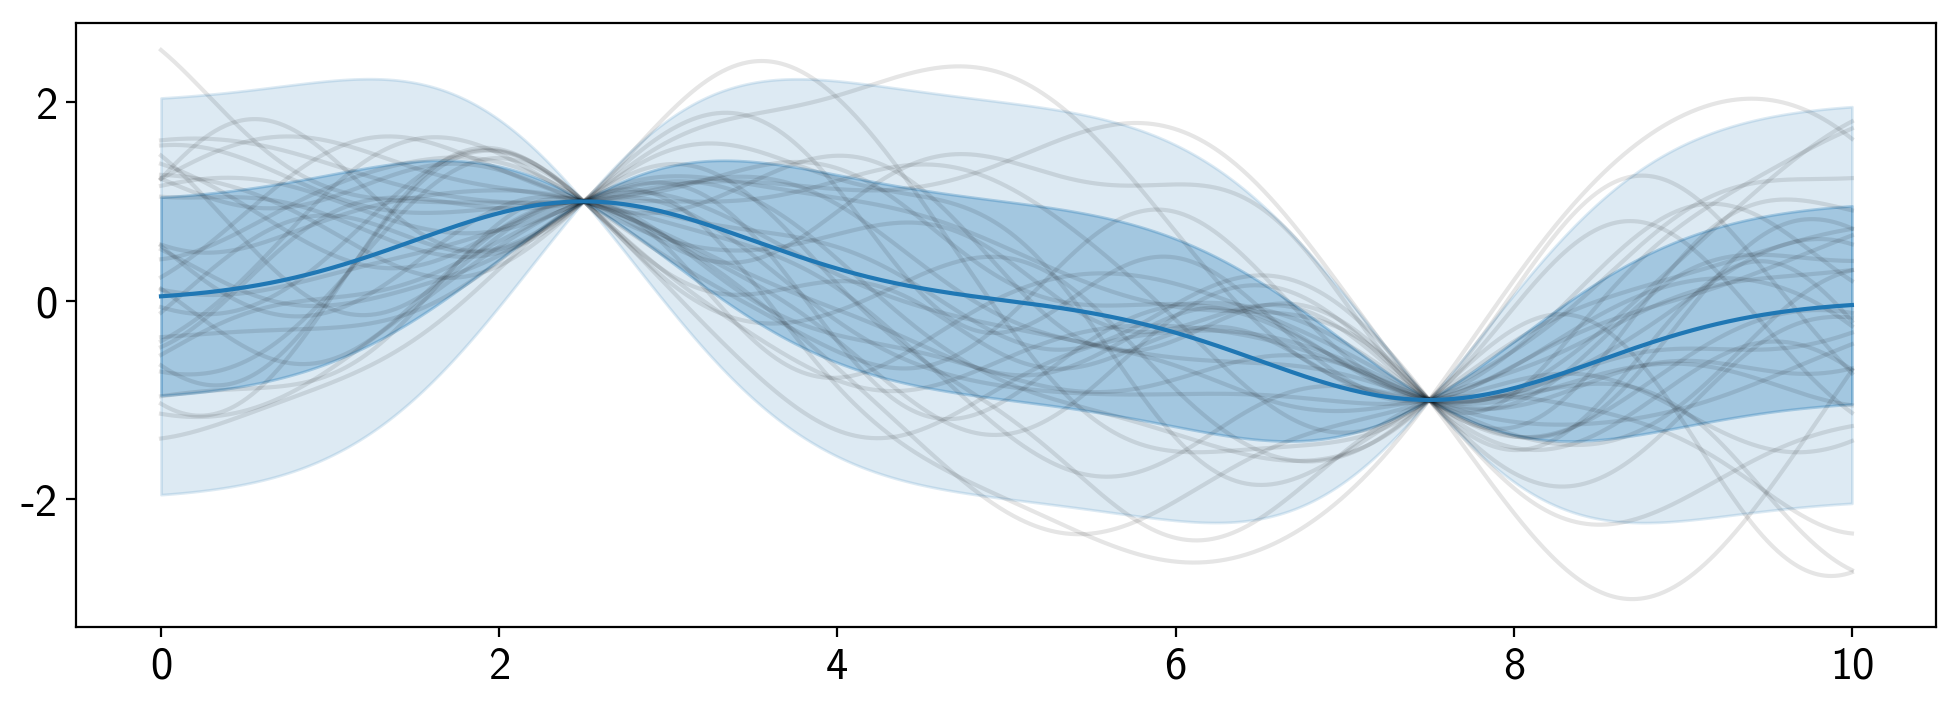

In [91]:
for i in range(30):
    samples = draw_from_gaussian(gp_mu, gp_K)
    plt.plot(t, samples, color="k", alpha=0.1)

plt.plot(t, gp_mu, color="C0")
std_ = np.sqrt(gp_K.diagonal())
plt.fill_between(t, gp_mu - std_, gp_mu + std_, color="C0", alpha=0.3);
plt.fill_between(t, gp_mu - 2 * std_, gp_mu + 2 * std_, color="C0", alpha=0.15);

In [121]:
def marginal_likelihood(t, y, sigma=0, kernel=ExpSinSquaredKernel, **kwargs):
    """
    
    """
    # The covariance and its determinant
    npts = len(t)
    K = kernel(t, **kwargs) + sigma ** 2 * np.eye(npts)
    detK = np.linalg.det(K)
    
    # The marginal likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= -0.5 * np.log(detK)
    log_like -= 0.5 * npts * np.log(2 * np.pi)
    
    return log_like

In [ ]:
# TODO: Dfm's fitting a line example.